## Imports

In [395]:
import numpy as np
import einops
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree

from shapely.geometry.polygon import Polygon
import shapely

import importlib

In [396]:
import bonds
import lattice
import utils
import plot_utils

In [397]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)


## Set up lattice

### Kagome

In [398]:
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome'
)

In [399]:
# lattice params for kagome lattice
nx = 6
ny = 6
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

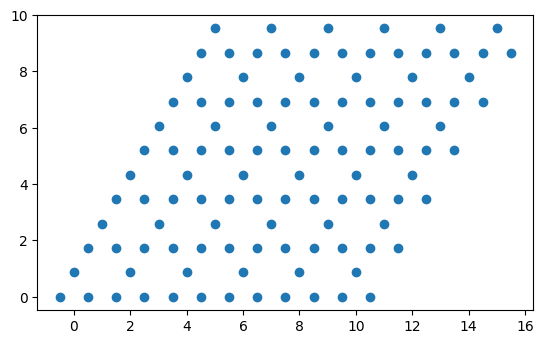

In [400]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

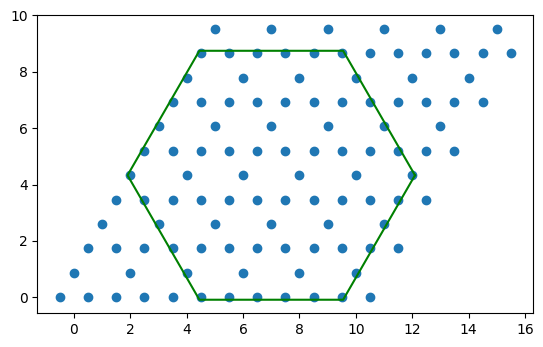

In [401]:
polygon = lattice.create_hexagon(5.1, 7, 5 * np.sqrt(3)/2)
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
x,y = polygon.exterior.xy
ax.plot(x,y, c='g', label="cut boundary")

In [402]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

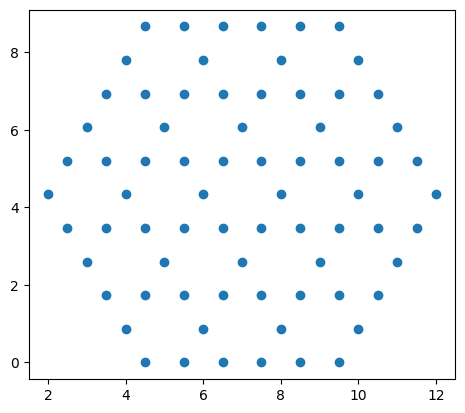

In [403]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=72 and $N_{\\rm bonds}=$126')

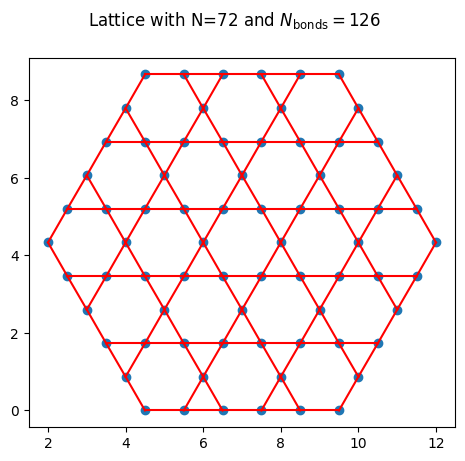

In [404]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [405]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

(7, 2, 2)
(6, 4)


IndexError: index 6 is out of bounds for axis 0 with size 6

> /Users/Yanting/Repositories/rydberg-vison/plot_utils.py(6)_plot_v_bonds()
      4   for i, v_pair in enumerate(v_pairs):
      5     if isinstance(c, np.ndarray):
----> 6       ax.plot(v_pair[:, 0], v_pair[:, 1], color=c[i])
      7     else:
      8       ax.plot(v_pair[:, 0], v_pair[:, 1], color=c)

(6, 4)
6
(7, 2, 2)


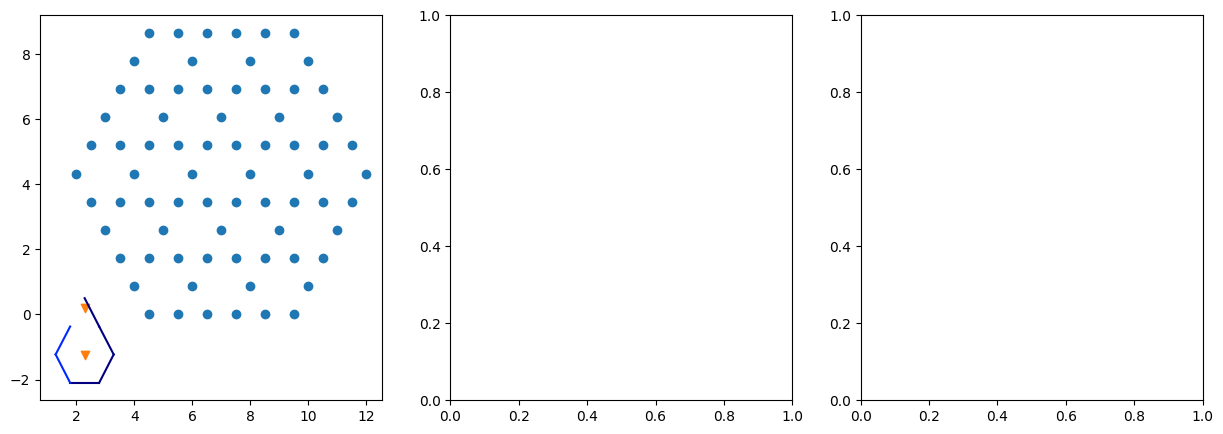

In [414]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,7))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    print(c.shape)
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

Automatic pdb calling has been turned ON


### Triangular

In [ ]:
# # lattice params for kagome lattice
# nx = 4
# ny = 3
# grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
#                'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 
#                'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
#                                  }
# mesh = lattice.create_grid_mesh(grid_params)
# BZ_kpoints = lattice.create_grid(grid_params)
# my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

In [ ]:
# lattice params for triangular lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0.,0.), 
               'unit_cell_bases':[np.array([0.,0.])] 
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

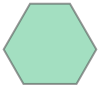

In [ ]:
# Define the polygon for the cut
height = np.sqrt(3)/2
epsilon = 0.01 # to shift the boundary of the polygon slightly so that the region counts correct points within the boundary
polygon = Polygon([(3 - epsilon, 0 - epsilon), (7 + epsilon, 0 - epsilon), (8.5 + epsilon, 3 * height + epsilon), 
                   (6.5 + epsilon, 7 * height + epsilon), (3.5 - epsilon, 7 * height + epsilon), (1.5 - epsilon, 3 * height + epsilon)])
polygon

In [ ]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

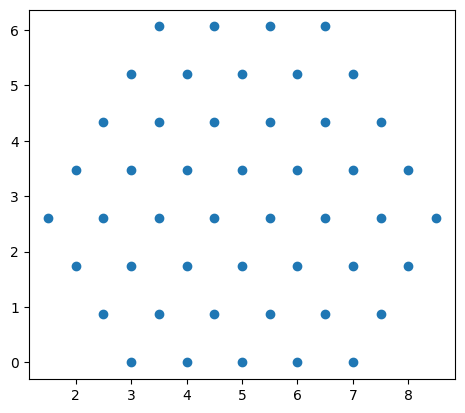

In [ ]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=48 and $N_{\\rm bonds}=$120')

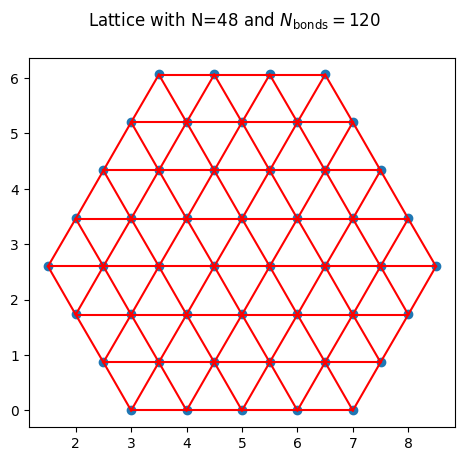

In [ ]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [ ]:
ListEB_comb = bonds.get_elementaryLoops((8, 8), 'triangular')
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

AttributeError: 'NoneType' object has no attribute 'lattice_type'

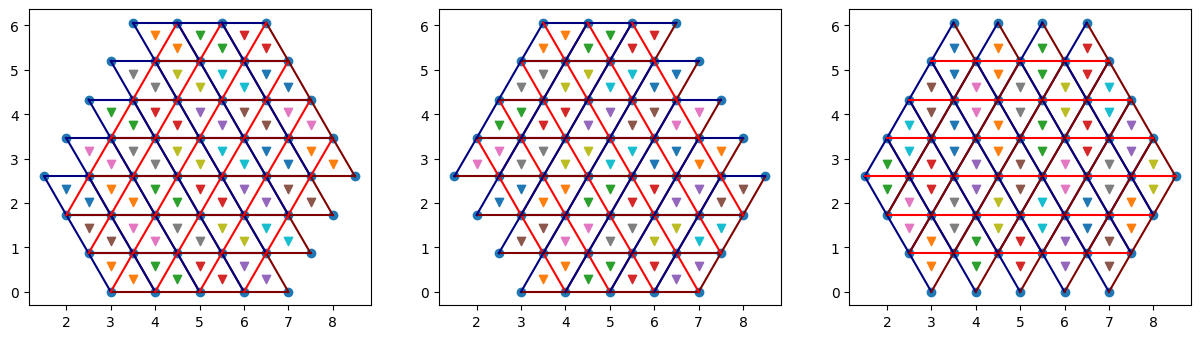

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")